In [1]:
%matplotlib inline
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
import time
import datetime
import pandas
import numpy
import scipy.stats
import tokio
import abcutils
import seaborn
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

## Load and Synthesize Data from CSV

In [4]:
filtered_df = abcutils.sc18paper.load_dataset()

Loading from cache cache.hdf5
Start with 14536 rows before filtering
Dropped 42 rows after filter #0 (14494 left)
Dropped 14 rows after filter #1 (14480 left)
Dropped 38 rows after filter #2 (14442 left)
Dropped 5 rows after filter #3 (14437 left)
Dropped 2451 rows after filter #4 (11986 left)
11986 rows remaining


In [5]:
TEST_PLATFORMS = [
#   'scratch1@edison',
    'cscratch@cori-knl',
    'mira-fs1@mira'
]
BENCHMARK_IDS = [
    'ior_shared_write',
    'ior_fpp_write',
    'hacc_io_write_fpp_write',
    'vpicio_uni_shared_write',
    'ior_shared_read',
    'ior_fpp_read',
    'hacc_io_read_fpp_read',
    'dbscan_read_shared_read'
]

plot_metric = 'darshan_normalized_perf_by_max'

group_by = ['_test_platform', '_benchmark_id']

print "plot_metric =", abcutils.CONFIG['metric_labels'].get(plot_metric, plot_metric)
print "date_start =", abcutils.sc18paper.DATE_START.isoformat()
print "date_end =", abcutils.sc18paper.DATE_END.isoformat()

plot_metric = Fraction Peak Perf
date_start = 2017-02-14T00:00:00
date_end = 2018-02-15T00:00:00


## Seaborn Heatmap

In [6]:
job_times = {}
heatmap_dat = {}
platform_groups = filtered_df.groupby('_test_platform')
for platform_id in TEST_PLATFORMS:
    platform_df = platform_groups.get_group((platform_id))
    job_ids = sorted(list(set(platform_df['_jobid'].values)))
    job_times[platform_id] = [platform_df[(platform_df['_jobid'] == jobid)]['_datetime_start'].values[0] for jobid in job_ids]
    heatmap_dat[platform_id] = pandas.DataFrame(0.0, index=job_ids, columns=BENCHMARK_IDS)
    benchmark_groups = platform_df.groupby(by='_benchmark_id')
    for benchmark_id in BENCHMARK_IDS:
        benchmark_df = benchmark_groups.get_group((benchmark_id)).set_index('_jobid')
        heatmap_dat[platform_id][benchmark_id] = benchmark_df[plot_metric]

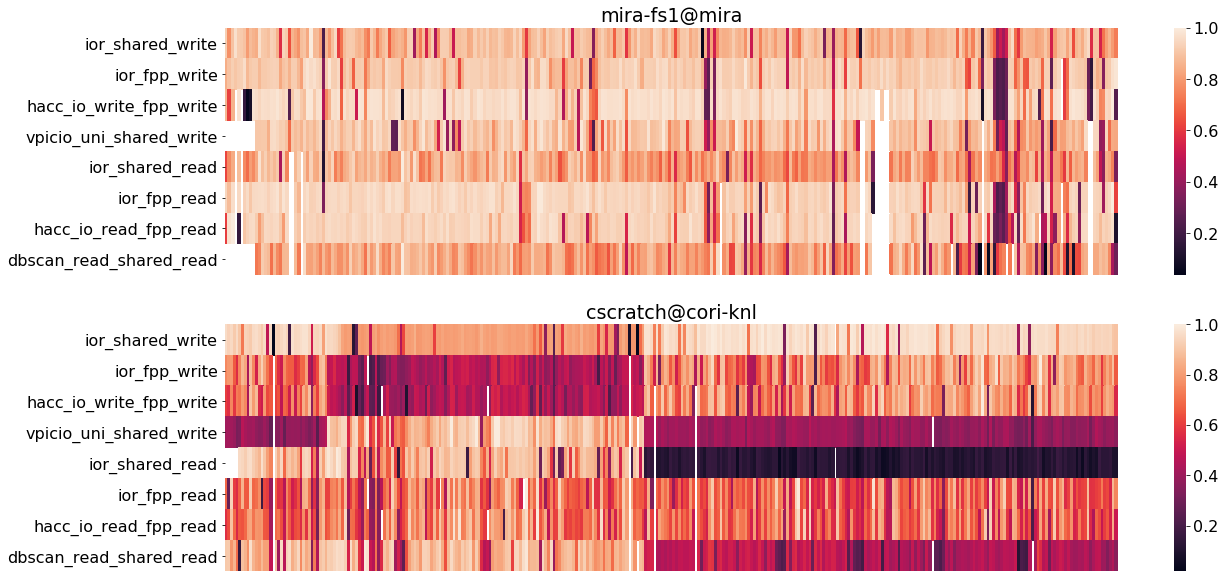

In [7]:
fig, axes = matplotlib.pyplot.subplots(nrows=len(heatmap_dat), ncols=1)
fig.set_size_inches(20, 5*len(heatmap_dat))
#matplotlib.pyplot.locator_params(nticks=4)

i = 0
for platform_id in heatmap_dat:
    tmp_df = heatmap_dat[platform_id].transpose()
    #tmp_df['_datetime_start'] = job_times[platform_id]
    #tmp_df = tmp_df.set_index('_datetime_start')
    #tmp_df = tmp_df.transpose()
    
    seaborn.heatmap(tmp_df, ax=axes[i])
    axes[i].set_title(platform_id)
    #axes[i].xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(10))
    axes[i].xaxis.label.set_visible(False)
    axes[i].set_xticks([])
    #axes[i].xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=1))
    #axes[i].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m-%d'))
    axes[i].get_figure().subplots_adjust(hspace=.2)
    i += 1

    #fig.autofmt_xdate()
pass

## Matplotlib Heatmap

In [8]:
def value2label(test_platform, benchmark_id):
    return "%s, %s" % (test_platform, benchmark_id)

In [9]:
columns = []
for benchmark_id in BENCHMARK_IDS:
    for test_platform in TEST_PLATFORMS:
        columns.append(value2label(test_platform, benchmark_id))

ts = tokio.timeseries.TimeSeries(dataset_name='blah',
                                 start=abcutils.sc18paper.DATE_START,
                                 end=abcutils.sc18paper.DATE_END,
                                 timestep=86400,
                                 num_columns=len(columns),
                                 column_names=sorted(columns),
                                 sort_hex=False)

In [10]:
example_df = filtered_df.copy()

test_filter = example_df['_benchmark_id'].isin(BENCHMARK_IDS)
test_filter &= example_df['_test_platform'].isin(TEST_PLATFORMS)
rename_filter = {
    '_datetime_start': 'datetime_start',
    '_benchmark_id': 'benchmark_id',
    '_test_platform': 'test_platform',
}
for row in example_df[test_filter].rename(rename_filter, axis='columns', inplace=False).itertuples():
    ts.insert_element(row.datetime_start.to_pydatetime(),
                      value2label(row.test_platform, row.benchmark_id),
                      row._asdict()[plot_metric])

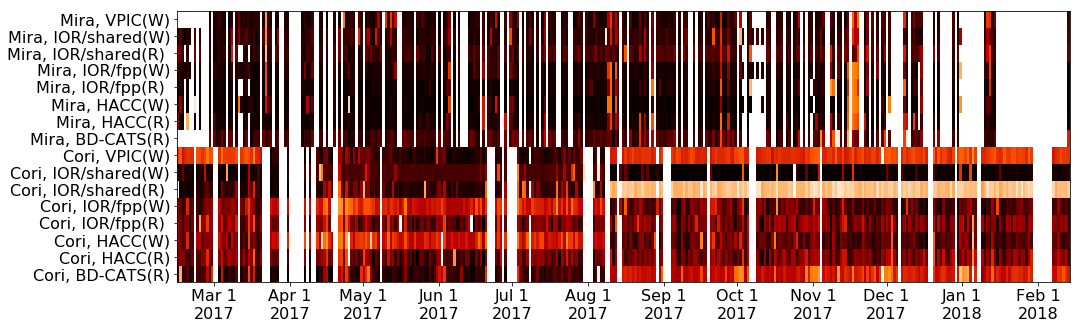

In [12]:
fig, ax = matplotlib.pyplot.subplots()
fig.set_size_inches(16, (2.5 * len(TEST_PLATFORMS)))

ax.pcolormesh(
    numpy.arange(ts.dataset.shape[0]),
    numpy.arange(ts.dataset.shape[1]+1),
    ts.dataset.T,
    cmap='gist_heat_r')

column_labels = []
for label in ts.columns:
    for key, val in abcutils.CONFIG['benchmark_labels_short'].iteritems():
        label = label.replace(key, val)
    label = label.replace('scratch1@edison', 'Edison')
    label = label.replace('cscratch@cori-knl', 'Cori')
    label = label.replace('mira-fs1@mira', 'Mira')

    column_labels.append(label)
    
# Set y ticks
ax.set_yticks(numpy.arange(len(column_labels)) + 0.5)
ax.set_yticklabels(column_labels, ha='right')

# Set x ticks
xticks = []
#xticks = [0] # always include first data point
for index, timestamp in enumerate(ts.timestamps):
    day = datetime.datetime.fromtimestamp(timestamp).day
    if day == 1 and index > 0: # include first of each month
        xticks.append(index)
#if day != 1:
#    xticks.append(index) # always include last data point
xticklabels = [datetime.datetime.fromtimestamp(ts.timestamps[index]).strftime("%b %d\n%Y").replace('01', '1', 1) for index in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)#, rotation=15, ha='right')
# ax.xaxis.grid(True)

ax.set_facecolor('black')

fig.savefig('figs/summary_heatmap.pdf', bbox_inches='tight')

In [ ]:
fig = plt.figure()
fig.set_size_inches(10,8)
fig.subplots_adjust(hspace=0.0, wspace=0.0)

gridspec = matplotlib.gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[3,1])

